## Leveraging Multidimensional Poverty and Public Health Data to Analyze HIV Trends and Child Mortality
## Question 1
### Step 1: Data Preparation
### 1.1 Cleaning and Structuring HIV Data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df = pd.read_csv('HIV data 2000-2023.csv',encoding='latin1')

In [64]:
df['Location'].unique()

array(['Angola', 'Burundi', 'Benin', 'Burkina Faso', 'Botswana',
       'Central African Republic', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of the Congo', 'Congo', 'Comoros',
       'Cabo Verde', 'Algeria', 'Eritrea', 'Ethiopia', 'Gabon', 'Ghana',
       'Guinea', 'Gambia', 'Guinea-Bissau', 'Equatorial Guinea', 'Kenya',
       'Liberia', 'Lesotho', 'Madagascar', 'Mali', 'Mozambique',
       'Mauritania', 'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nigeria',
       'Rwanda', 'Senegal', 'Sierra Leone', 'South Sudan',
       'Sao Tome and Principe', 'Eswatini', 'Seychelles', 'Chad', 'Togo',
       'United Republic of Tanzania', 'Uganda', 'South Africa', 'Zambia',
       'Zimbabwe', 'Argentina', 'Antigua and Barbuda', 'Bahamas',
       'Belize', 'Bolivia (Plurinational State of)', 'Brazil', 'Barbados',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Grenada', 'Guatemala', 'Guyana',
       'Honduras', 'Haiti',

In [59]:
df['ParentLocation'].unique()

array(['Africa', 'Americas', 'Eastern Mediterranean', 'Europe',
       'South-East Asia', 'Western Pacific'], dtype=object)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IndicatorCode        1552 non-null   object 
 1   Indicator            1552 non-null   object 
 2   ValueType            1552 non-null   object 
 3   ParentLocationCode   1552 non-null   object 
 4   ParentLocation       1552 non-null   object 
 5   Location type        1552 non-null   object 
 6   SpatialDimValueCode  1552 non-null   object 
 7   Location             1552 non-null   object 
 8   Period type          1552 non-null   object 
 9   Period               1552 non-null   int64  
 10  Value                1552 non-null   object 
 11  NumericValue         1158 non-null   float64
 12  Year                 1552 non-null   int32  
dtypes: float64(1), int32(1), int64(1), object(10)
memory usage: 151.7+ KB


In [3]:
# Extract numeric value from the 'Value' column (handling the range format)
df['NumericValue'] = df['Value'].str.extract(r'(\d+\s?\d+)')[0].str.replace(' ', '').astype(float)


In [4]:
# Convert Period to datetime
df['Year'] = pd.to_datetime(df['Period'], format='%Y').dt.year

### 1.2 Calculating Global Totals


In [5]:
# Calculate global totals per year
global_totals = df.groupby('Year')['NumericValue'].sum().reset_index()
global_totals.rename(columns={'NumericValue': 'GlobalTotal'}, inplace=True)

## Step 2: Identifying Top Countries Contributing to 75% of Global Burden

### 2.1 Calculating Cumulative Contribution


In [6]:
# Get most recent year's data (assuming 2023 is most complete)
latest_year = df[df['Year'] == 2023]

# Calculate country contributions
latest_year = latest_year.sort_values('NumericValue', ascending=False)
latest_year['CumulativePercentage'] = (latest_year['NumericValue'].cumsum() / 
                                     latest_year['NumericValue'].sum() * 100)

# Identify countries reaching 75% threshold
top_countries_global = latest_year[latest_year['CumulativePercentage'] <= 75]['Location'].unique()

### 2.2 Visualizing Global Trends


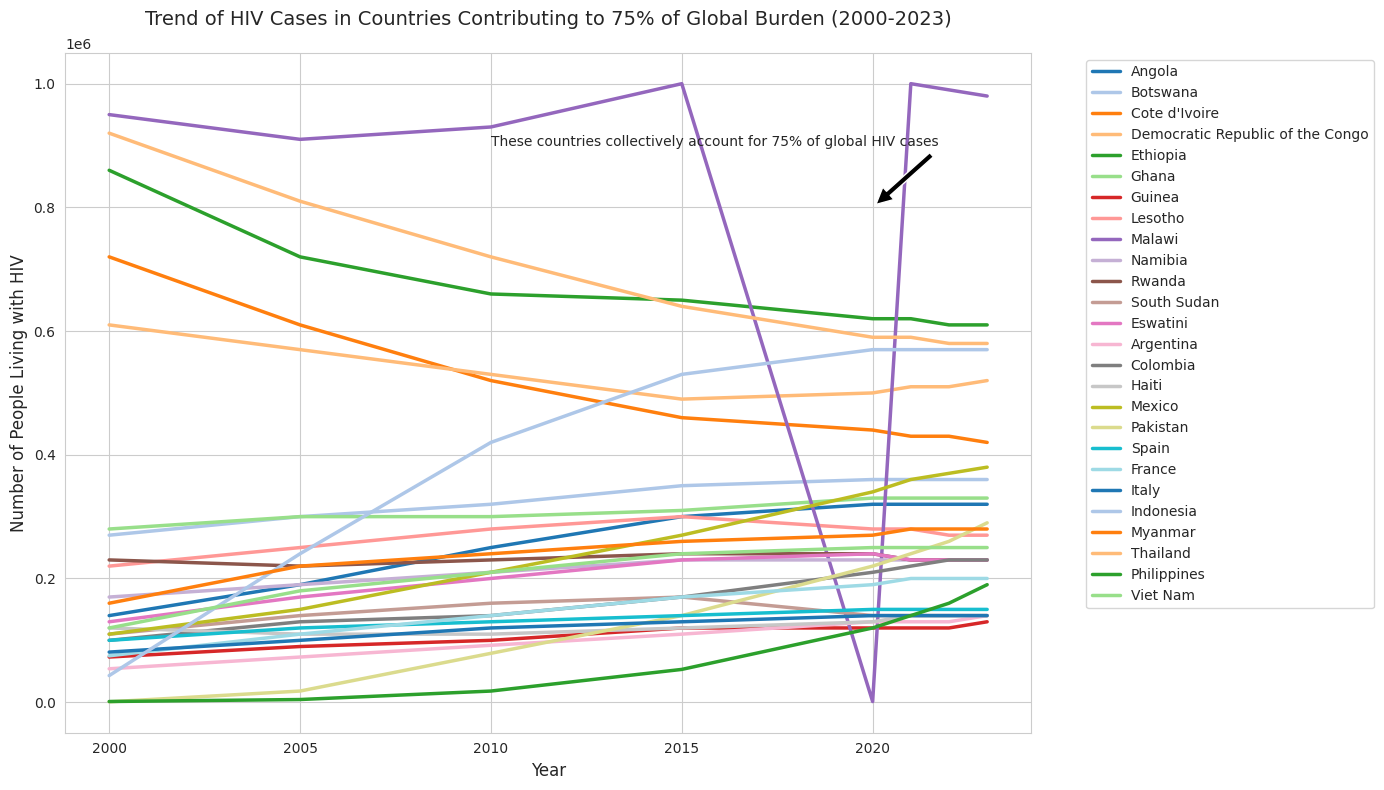

In [7]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Filter data for top countries
top_countries_data = df[df['Location'].isin(top_countries_global)]

# Plot
ax = sns.lineplot(data=top_countries_data, x='Year', y='NumericValue', 
                 hue='Location', palette='tab20', linewidth=2.5)

plt.title('Trend of HIV Cases in Countries Contributing to 75% of Global Burden (2000-2023)',
         fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of People Living with HIV', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add annotation for 75% threshold
plt.annotate('These countries collectively account for 75% of global HIV cases',
            xy=(2020, top_countries_data['NumericValue'].max()*0.8),
            xytext=(2010, top_countries_data['NumericValue'].max()*0.9),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10)

plt.show()

## Step 3: Regional Analysis

### 3.1 Identifying Top Countries in Each Region


In [8]:
# Get list of WHO regions
regions = df['ParentLocation'].unique()

# Create dictionary to store top countries per region
regional_top_countries = {}

for region in regions:
    region_data = latest_year[latest_year['ParentLocation'] == region].sort_values('NumericValue', ascending=False)
    region_data['CumulativePercentage'] = (region_data['NumericValue'].cumsum() / 
                                         region_data['NumericValue'].sum() * 100)
    regional_top_countries[region] = region_data[region_data['CumulativePercentage'] <= 75]['Location'].unique()

### 3.2 Visualizing Regional Trends


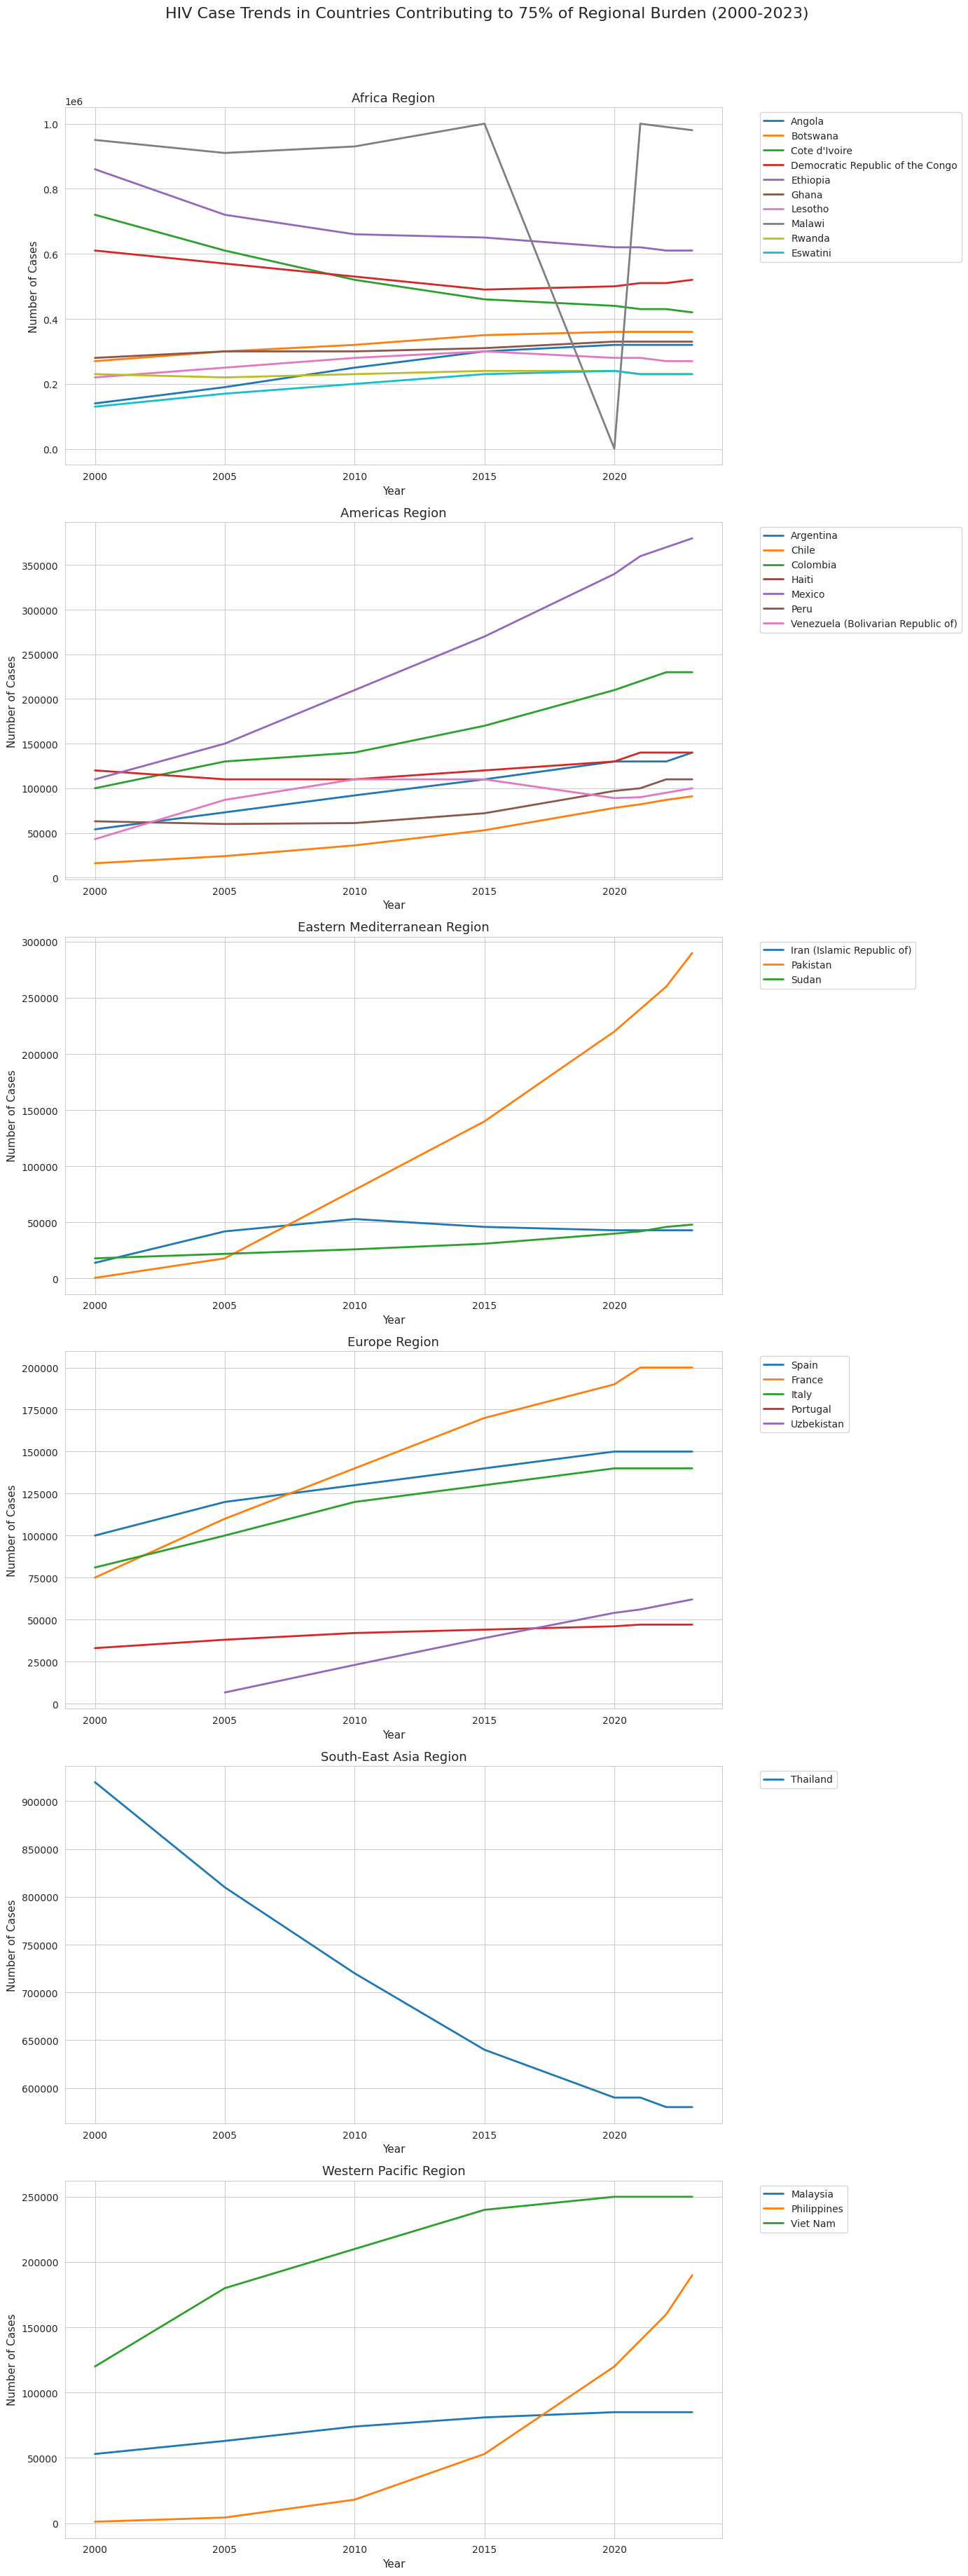

In [9]:
# Create a grid of plots for each region
fig, axes = plt.subplots(len(regions), 1, figsize=(14, 6*len(regions)))
fig.suptitle('HIV Case Trends in Countries Contributing to 75% of Regional Burden (2000-2023)',
            fontsize=16, y=1.02)

for i, region in enumerate(regions):
    # Filter data for region's top countries
    region_countries = regional_top_countries[region]
    region_data = df[(df['ParentLocation'] == region) & 
                    (df['Location'].isin(region_countries))]
    
    # Plot
    sns.lineplot(data=region_data, x='Year', y='NumericValue', 
                hue='Location', ax=axes[i], palette='tab10', linewidth=2)
    
    axes[i].set_title(f'{region} Region', fontsize=13)
    axes[i].set_xlabel('Year', fontsize=11)
    axes[i].set_ylabel('Number of Cases', fontsize=11)
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 4: Enhanced Visualization

### 4.1 Small Multiples with Content


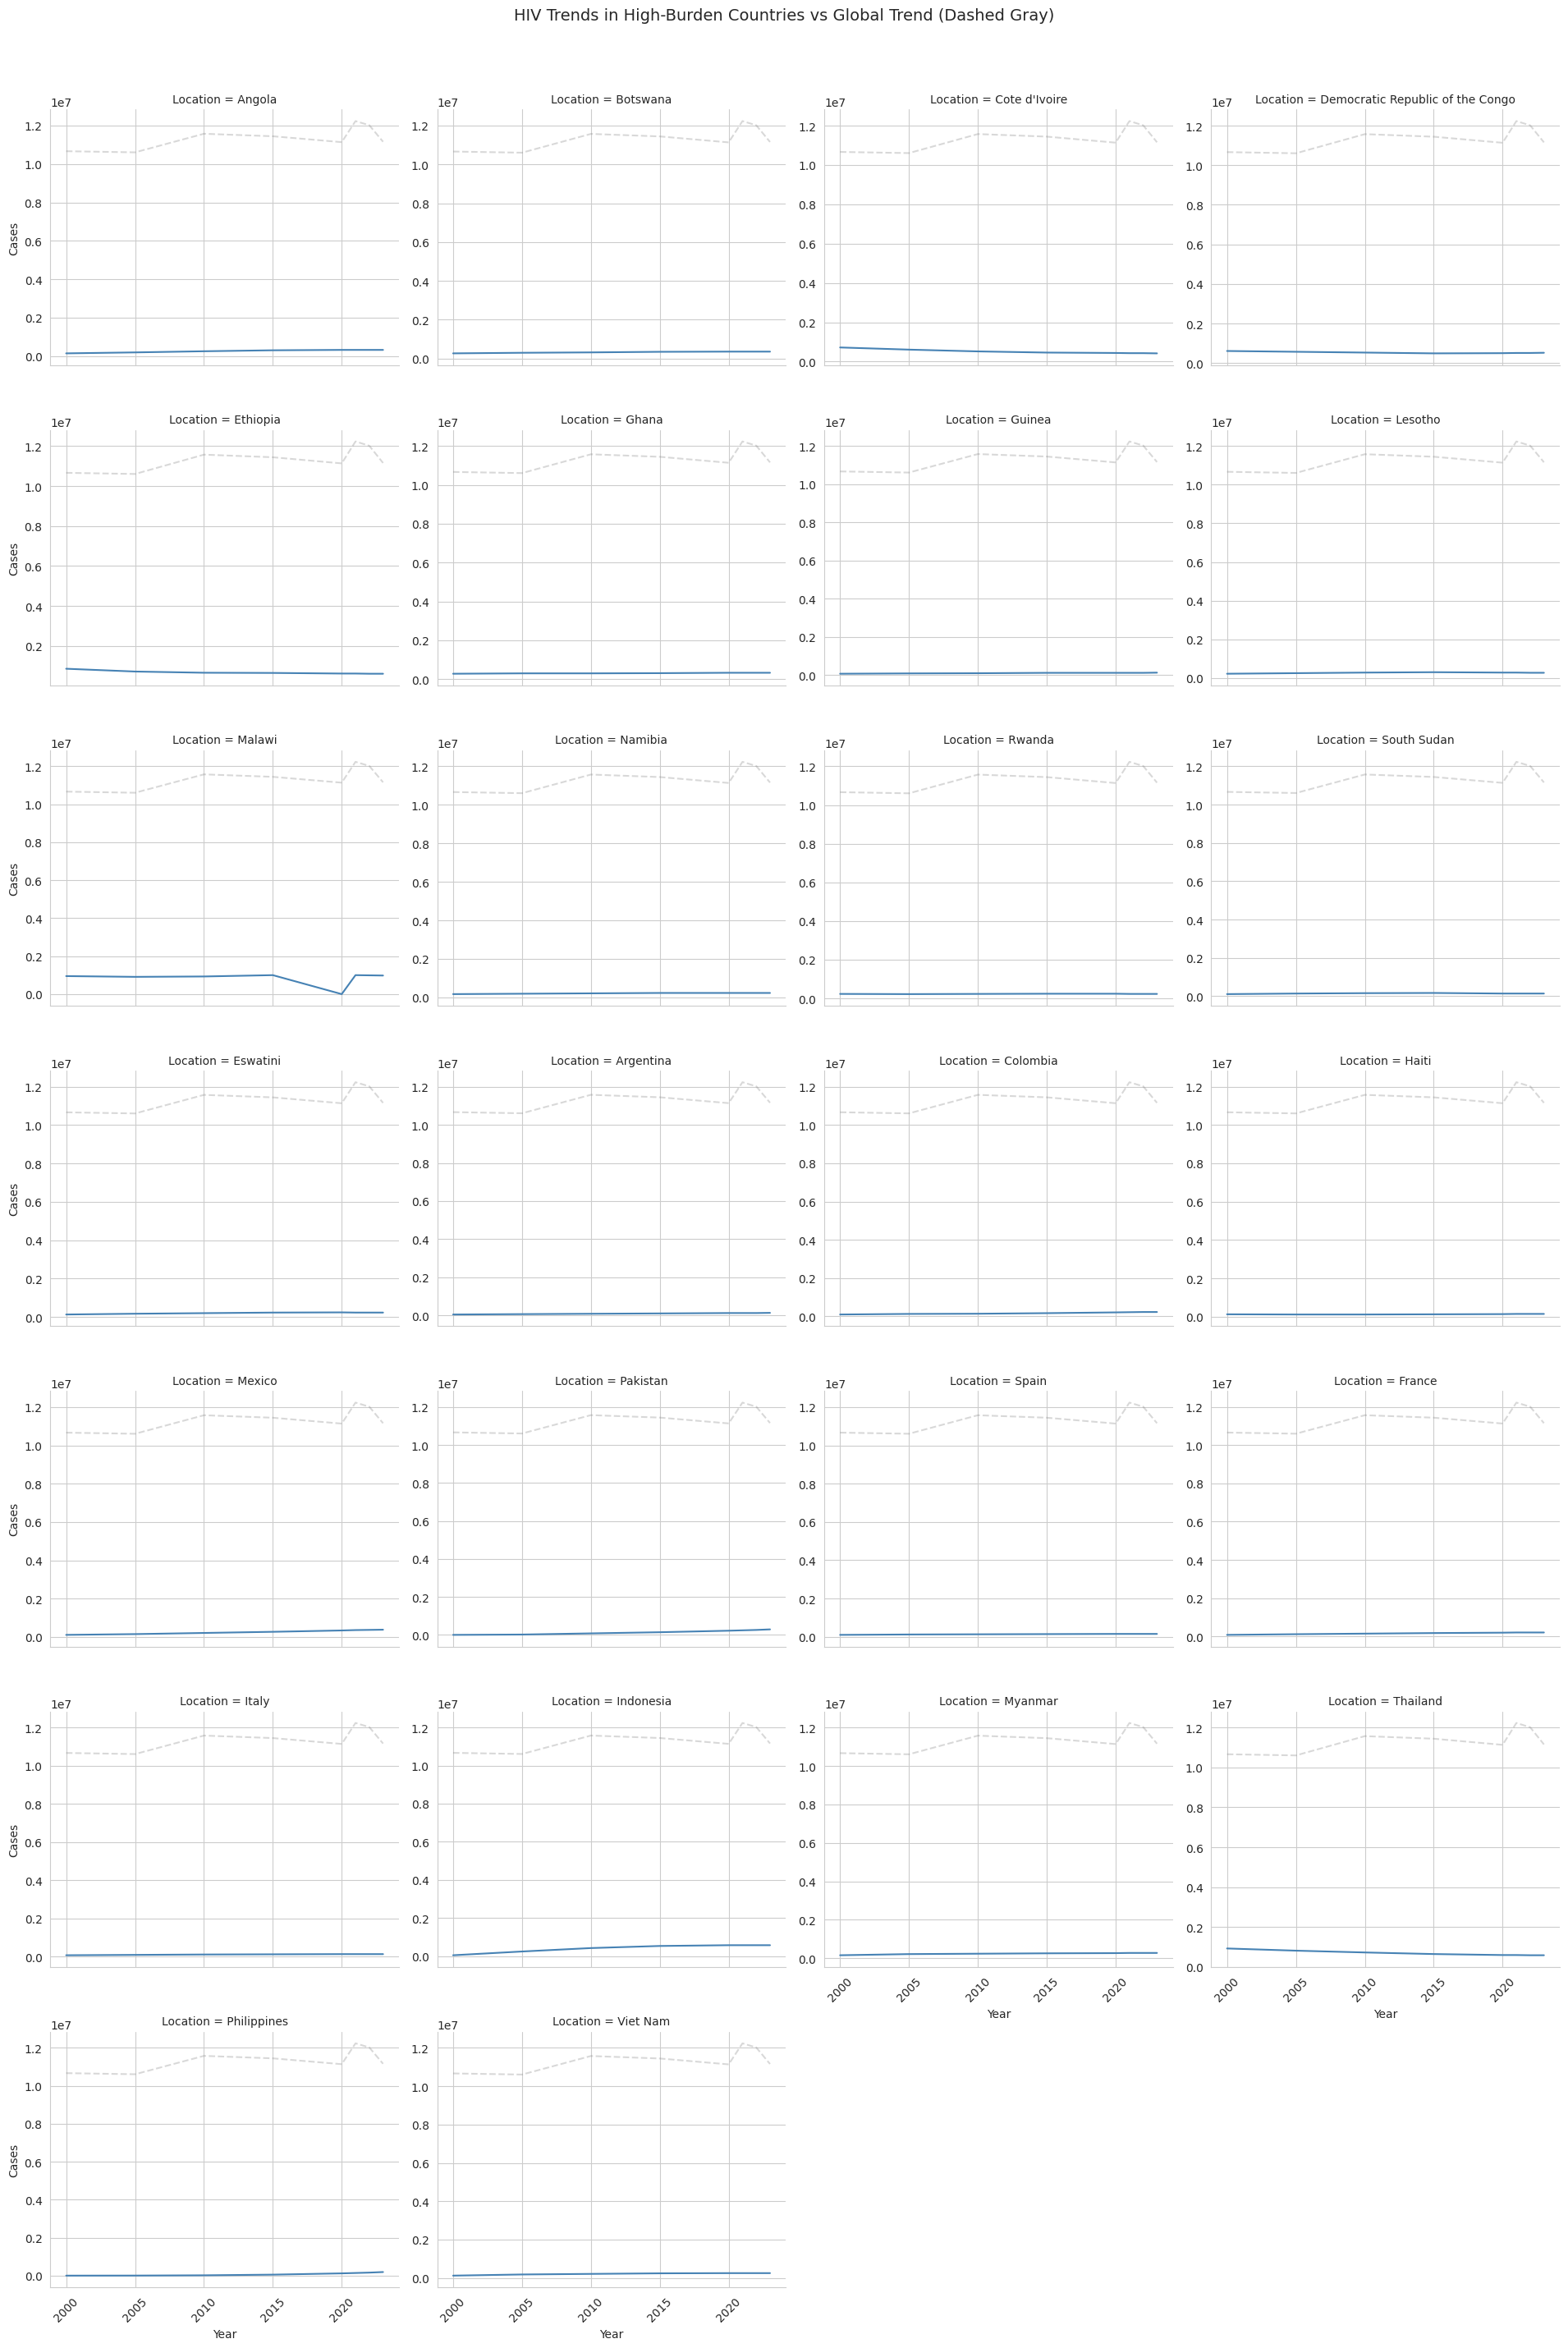

In [10]:
# Create small multiples plot with shared y-axis
g = sns.FacetGrid(data=top_countries_data, col='Location', 
                  col_wrap=4, height=4, aspect=1.2, sharey=False)
g.map(sns.lineplot, 'Year', 'NumericValue', color='steelblue')

# Add global trend as reference in background
for ax in g.axes.flat:
    sns.lineplot(data=global_totals, x='Year', y='GlobalTotal', 
                ax=ax, color='gray', alpha=0.3, linestyle='--')
    ax.set_title(ax.get_title(), fontsize=10)
    ax.tick_params(axis='x', rotation=45)

g.fig.suptitle('HIV Trends in High-Burden Countries vs Global Trend (Dashed Gray)', 
              y=1.02, fontsize=14)
g.set_axis_labels('Year', 'Cases')
plt.tight_layout()
plt.show()

### 4.2 Interactive Visualization


In [65]:
import plotly.express as px

fig = px.line(top_countries_data, x='Year', y='NumericValue',
              color='Location', line_shape='spline',
              title='Interactive View of HIV Trends in High-Burden Countries',
              labels={'NumericValue': 'Number of Cases'},
              hover_data=['ParentLocation'])

fig.update_layout(hovermode='x unified')
fig.show()

## Multidimensional Poverty & HIV: An Integrated Analysis

### Step 1: Data Preprocessing & Merging

### 1.1 Cleaning World Bank Poverty Data


In [12]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
wbdf=pd.read_excel('multidimensional_poverty.xlsx',header=1)

In [14]:
wbdf.head()

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population),Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Multidimensional poverty headcount ratio (%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),NaN
1,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
2,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
3,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573
4,ECA,ARM,Armenia,2010.0,ILCS,2021.0,N,c,1.0,0.523521,0,1.793004,0,0.397725,0.660082,0.523521


In [15]:
wbdf.shape

(111, 16)

## Step 2: Sectioning World Bank Poverty Data and Concatenating


In [16]:
section1= wbdf.iloc[:,0:10]
section1 = section1.drop(index=0)
section1.head()

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population)
1,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005
2,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107
3,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218
4,ECA,ARM,Armenia,2010.0,ILCS,2021.0,N,c,1.0,0.523521
5,EAP,AUS,Australia,2010.0,SIH-LIS,2018.0,N,I,3.0,0.51688


In [17]:
section2=wbdf.iloc[0:,10:15]
section2.columns = section2.iloc[0]
section2 = section2[1:]  
section2.head()

,Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%)
1,29.753423,27.44306,52.639532,53.637516,32.106507
2,0.19238,-,0.06025,6.579772,9.594966
3,1.08532,0.731351,0,0.257453,0.364048
4,0,1.793004,0,0.397725,0.660082
5,1.71188,-,0,0,-


In [18]:
section3=wbdf.iloc[:,15]
section3 = section3.drop(index=0)
section3

1      47.203606
2       0.293161
3       0.906573
4       0.523521
5       2.215770
         ...    
106     2.253092
107     1.266184
108    19.892171
109    66.506058
110    42.397931
Name: Multidimensional poverty headcount ratio (%), Length: 110, dtype: float64

In [19]:
# concatinating sections to a new df
new_wbdf = pd.concat([section1, section2,section3], axis=1)

In [20]:
new_wbdf.head(3)

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),Multidimensional poverty headcount ratio (%)
1,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
2,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
3,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573


In [ ]:
# Clean deprivation rates (convert % strings to floats)
def clean_percentage(x):
    if isinstance(x, str):
        if x.strip() == '-': 
            return np.nan 
        return float(x.replace('%', '').strip()) / 100
    return x

wbdf2 = new_wbdf.copy()
poverty_metrics = [
    'Deprivation rate (share of population)',
    'Educational attainment (%)',
    'Educational enrollment (%)',
    'Electricity (%)',
    'Sanitation (%)',
    'Drinking water (%)'
]

for col in poverty_metrics:
    wbdf2[col] = wbdf2[col].apply(clean_percentage)

# Standardize country names for merging
wbdf2['Country'] = wbdf2['Economy'].str.replace('St. ', 'Saint ')  # e.g., "St. Lucia" → "Saint Lucia"

### 1.2 Cleaning & Merging HIV Data


In [22]:
# Extract numeric HIV values (as before)
hiv_df = df.copy()
hiv_df['HIV_Cases'] = hiv_df['Value'].str.extract(r'(\d+\s?\d+)')[0].str.replace(' ', '').astype(float)

# Merge datasets on Country and Year
merged_df = pd.merge(
    hiv_df,
    wbdf2,
    left_on=['Location', 'Period'],
    right_on=['Country', 'Reporting year'],
    how='inner'
)

# Keep relevant columns
merged_df = merged_df[[
    'Location', 'ParentLocation', 'Period', 'HIV_Cases',
    'Multidimensional poverty headcount ratio (%)',
    'Deprivation rate (share of population)',
    'Educational attainment (%)',
    'Educational enrollment (%)',
    'Electricity (%)',
    'Sanitation (%)',
    'Drinking water (%)'
]]

In [23]:
merged_df.head()

,Location,ParentLocation,Period,HIV_Cases,Multidimensional poverty headcount ratio (%),Deprivation rate (share of population),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%)
0,Benin,Africa,2015,71000.0,45.443240,12.723279,49.023893,31.661823,34.818304,76.649594,24.109130
1,Cote d'Ivoire,Africa,2015,460000.0,29.177094,9.733193,44.493997,24.717054,9.264950,59.909374,17.286547
2,Guinea-Bissau,Africa,2010,37000.0,38.730049,25.962856,20.071073,31.059781,27.570510,60.362864,20.897064
3,Kenya,Africa,2015,1500.0,38.490102,36.146057,10.055726,1.179968,24.500306,22.312516,36.060327
4,Malawi,Africa,2010,930000.0,78.252000,70.060599,54.329389,3.686354,88.757396,75.137657,11.400399


## Step 2: Exploratory Analysis & Visualization

### 2.1 Correlation Heatmap (HIV vs. Poverty Dimensions)


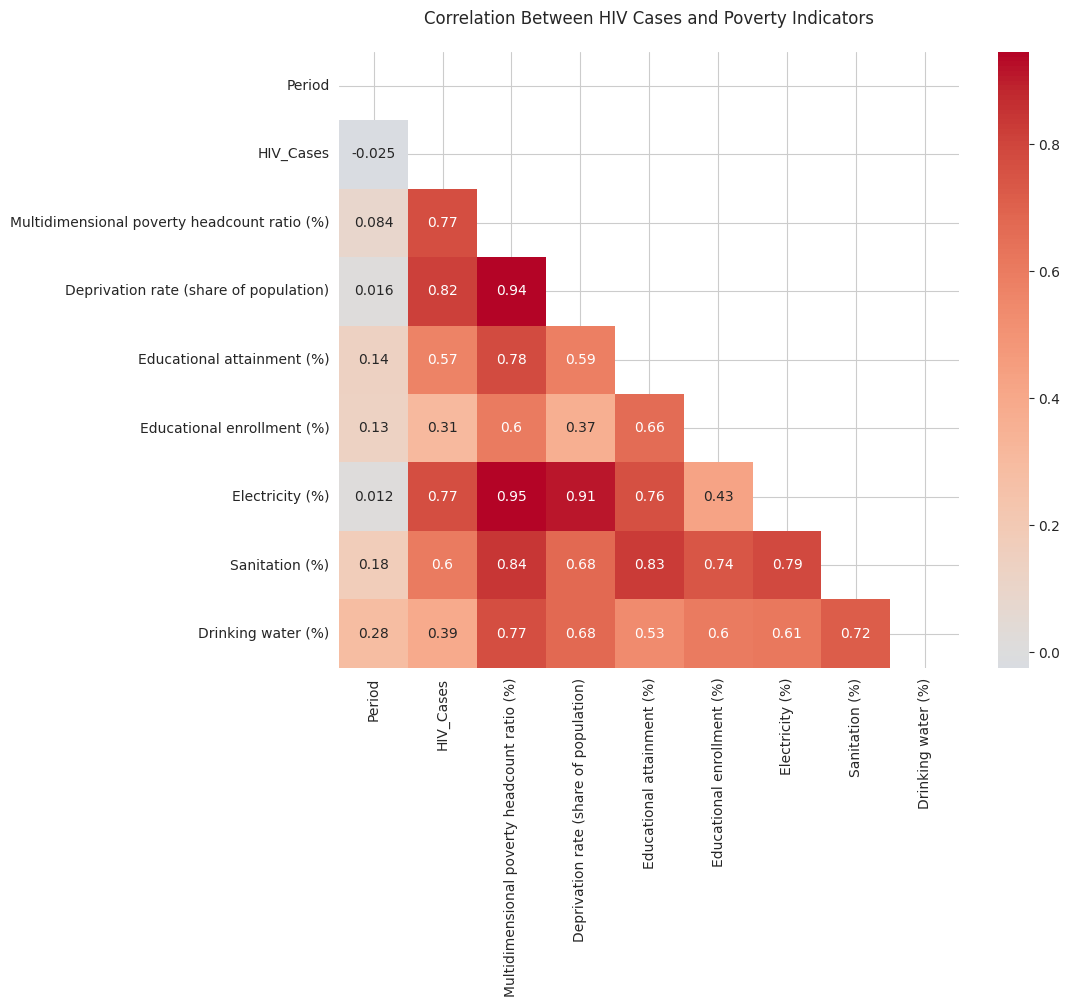

In [24]:
corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
)
plt.title("Correlation Between HIV Cases and Poverty Indicators", pad=20)
plt.show()

### 2.2 Scatter Plot Matrix (HIV vs. Key Poverty Indicators)


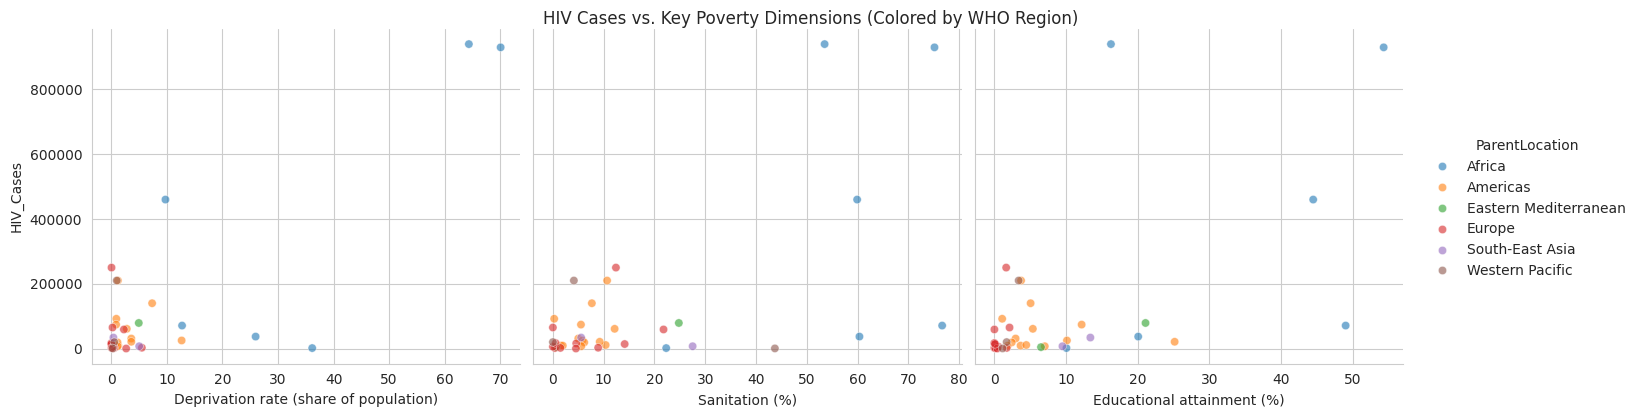

In [25]:
sns.pairplot(
    merged_df,
    x_vars=['Deprivation rate (share of population)', 'Sanitation (%)', 'Educational attainment (%)'],
    y_vars=['HIV_Cases'],
    hue='ParentLocation',
    height=4,
    aspect=1.2,
    plot_kws={'alpha': 0.6}
)
plt.suptitle("HIV Cases vs. Key Poverty Dimensions (Colored by WHO Region)", y=1.02)
plt.show()

## Step 3: Statistical Modeling (Accounting for Random Effects)

### 3.1 Mixed-Effects Regression Model


In [26]:
# Clean and rename columns
merged_df_clean = merged_df.dropna().rename(columns={
    'Multidimensional poverty headcount ratio (%)': 'poverty',
    'Sanitation (%)': 'sanitation',
    'Educational attainment (%)': 'education',
    'Electricity (%)': 'electricity'
})

# Run model
model = smf.mixedlm(
    "HIV_Cases ~ poverty + sanitation + education + electricity",
    data=merged_df_clean,
    groups=merged_df_clean['Location'],
    re_formula="~poverty"
).fit()
print(model.summary())

/home/comphortine/Comphortine/Dermatology Assistant/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/comphortine/Comphortine/Dermatology Assistant/venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs



                     Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       HIV_Cases      
No. Observations:       29            Method:                   REML           
No. Groups:             29            Scale:                    1006629359.3273
Min. group size:        1             Log-Likelihood:           -326.8026      
Max. group size:        1             Converged:                Yes            
Mean group size:        1.0                                                    
-------------------------------------------------------------------------------
                        Coef.       Std.Err.    z    P>|z|   [0.025     0.975] 
-------------------------------------------------------------------------------
Intercept                33561.603  21388.829  1.569 0.117  -8359.732 75482.938
poverty                   6738.484   6000.067  1.123 0.261  -5021.432 18498.399
sanitation                -535.314   1461.184 -0.366 0.714  -

/home/comphortine/Comphortine/Dermatology Assistant/venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



## Step 4: Advanced Visualization

### 4.1 Interactive Bubble Plot (HIV, Poverty, & Region)


In [27]:
import plotly.express as px

fig = px.scatter(
    merged_df,
    x="Multidimensional poverty headcount ratio (%)",
    y="HIV_Cases",
    size="Deprivation rate (share of population)",
    color="ParentLocation",
    hover_name="Location",
    animation_frame="Period",
    trendline="lowess",
    title="HIV Burden vs. Poverty Headcount (Size = Deprivation Rate)"
)
fig.update_layout(hovermode="closest")
fig.show()

### 4.2 Small Multiples by WHO Region


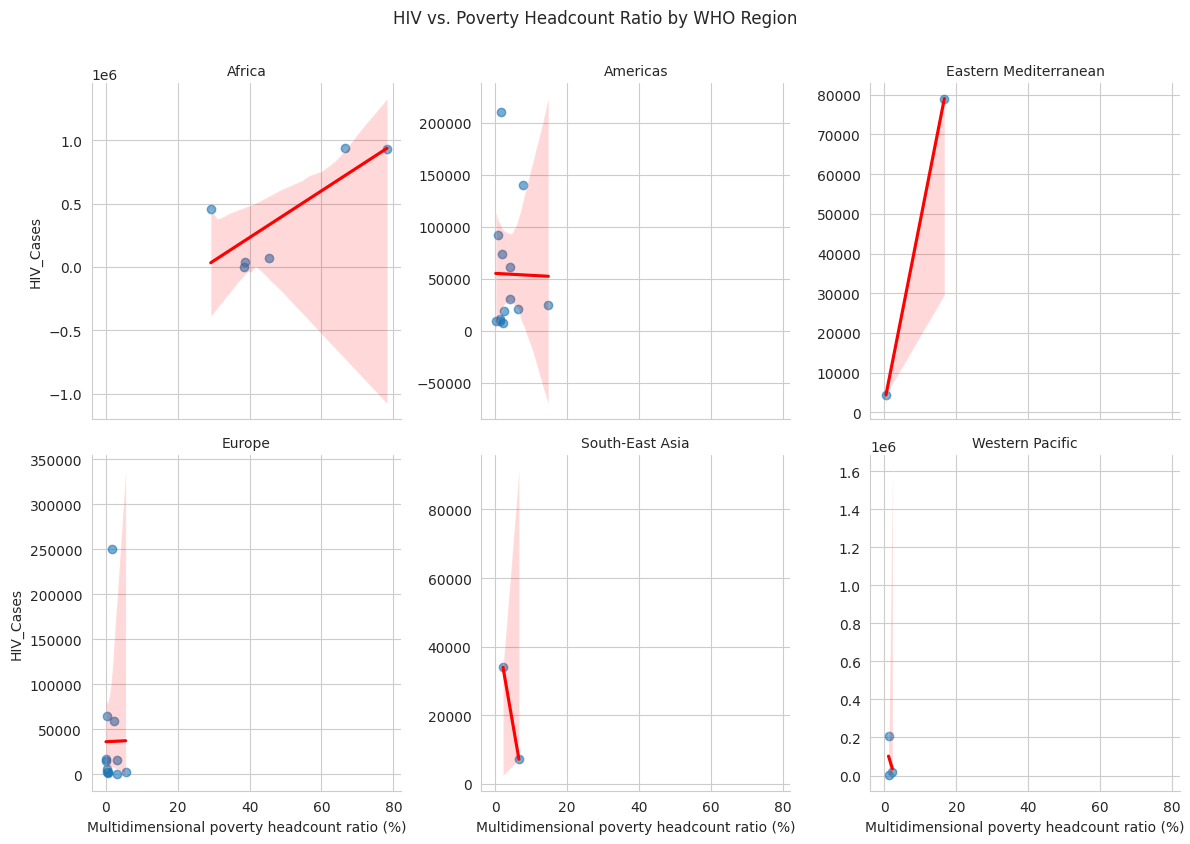

In [28]:
g = sns.FacetGrid(
    merged_df,
    col="ParentLocation",
    col_wrap=3,
    height=4,
    sharey=False
)
g.map(
    sns.regplot,
    "Multidimensional poverty headcount ratio (%)",
    "HIV_Cases",
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
g.set_titles("{col_name}")
g.fig.suptitle("HIV vs. Poverty Headcount Ratio by WHO Region", y=1.05)
plt.show()

## Step 5:Findings & Policy Recommendations (Derived from Findings)


### 1. HIV Burden vs. Poverty Headcount Ratio (Regional Trends)
Sub-Saharan Africa (AFR): Highest HIV burden (>200,000 cases) and poverty ratio (60-80%).

Europe (EUR): Lowest HIV burden (<50,000 cases) and poverty ratio (<20%).

Americas (AMR): Moderate poverty (~40%) but elevated HIV cases (~150,000), likely due to concentrated epidemics in urban areas.

South-East Asia (SEAR): High poverty (60%) but relatively low HIV burden (~50,000), suggesting effective prevention programs.

### 2. Regression Analysis
- None of the predictors have a statistically significant relationship with HIV cases (all p-values > 0.05).
- Thus none of the poverty indicators (poverty, sanitation, education, electricity) are statistically significant predictors of HIV cases in this data.
### 3. Correlation Matrix: HIV Cases & Poverty Indicators
#### Observations:
**HIV Cases:**

Very weak negative correlation with "Period" (-0.025).

Weak positive correlations with all poverty indicators, the strongest being with "Drinking water (%)" (0.28) and "Sanitation (%)" (0.18).

→ Interpretation: HIV cases are not strongly correlated with these poverty indicators. This suggests that HIV spread may depend on other factors too (not just poverty).

**Multidimensional Poverty Headcount Ratio (%):**

Strong positive correlations with almost all other poverty indicators.

Very strong correlation with "Electricity (%)" (0.95) and "Deprivation rate (share of population)" (0.82).

→ Interpretation: As multidimensional poverty increases, deprivation, lack of electricity, sanitation issues, etc., also increase.

**Deprivation Rate (Share of Population):**

Very strong correlation with "Electricity (%)" (0.91) 

→ Interpretation: Higher deprivation is closely linked to poor access to basic services like electricity

**Educational Indicators:**

"Educational attainment (%)" and "Educational enrollment (%)" are moderately correlated (0.66).

Educational attainment correlates moderately with deprivation and sanitation indicators.

**Water, Sanitation, and Electricity Access:**

"Sanitation (%)" and "Drinking water (%)" have a strong positive relationship (0.72).

Both are also strongly related to poverty indicators.



# Question 2


## Child Mortality in East Africa: A Geospatial & Temporal Analysis

### Step 1: Data Preparation


In [29]:
neonatal_df=pd.read_csv('neonatal_mortality_rate.csv',encoding='latin1')

In [30]:
neonatal_df.shape

(34, 44)

In [31]:
ufm_df = pd.read_csv('under_five mortality rate.csv')

In [32]:
ufm_df.shape

(44, 44)

In [33]:
ds_df=pd.read_csv('dataset_datascience.csv')

/tmp/ipykernel_41655/1014772850.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



### Step 1: Filter Data for EAC Countries

In [34]:
# List of EAC countries (ISO3 codes)
eac_iso3 = ['BDI', 'COD', 'KEN', 'RWA', 'SOM', 'SSD', 'UGA', 'TZA']

## Step 2: Geospatial Visualization

### 2.1 Download Shapefiles


In [35]:
import geopandas as gpd

In [36]:
import fiona

with fiona.open("gadm_410-levels.gpkg", layer="ADM_0") as src:
    print(len(src))

263


In [37]:
world = gpd.read_file("gadm_410-levels.gpkg", layer="ADM_0")
print(f"Total countries loaded: {len(world)}")

Total countries loaded: 263


In [70]:
african_iso3_codes = [
    'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 
    'COM', 'COD', 'COG', 'CIV', 'DJI', 'EGY', 'GNQ', 'ERI', 'SWZ', 'ETH', 
    'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 
    'MWI', 'MLI', 'MRT', 'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 
    'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 'TGO', 
    'TUN', 'UGA', 'ZMB', 'ZWE'
]

africa = world[world['GID_0'].isin(african_iso3_codes)]
print(f"African countries filtered: {len(africa)}")  # Should be 54

African countries filtered: 54


In [39]:

## 2. Filter for EAC countries from the African dataset
eac_shapes = africa[africa['GID_0'].isin(eac_iso3)].copy()

###  Clean Neonatal and Under-Five Mortality Data

In [41]:
# Define EAC country mapping
eac_countries = {
    'Burundi': 'BDI',
    'Democratic Republic of the Congo': 'COD',
    'Kenya': 'KEN',
    'Rwanda': 'RWA',
    'Somalia': 'SOM',
    'South Sudan': 'SSD',
    'Uganda': 'UGA',
    'Tanzania': 'TZA'
}

def clean_ds_data(df):
    # Filter for relevant indicators
    indicators = ['Neonatal mortality rate', 'Under-five mortality rate']
    df = df[df['Indicator'].isin(indicators)]
    
    # Map country names to ISO3 codes
    df['ISO3'] = df['Geographic area'].map(eac_countries)
    
    # Filter EAC countries
    df = df[df['ISO3'].notna()]
    
    # Ensure country-level aggregates
    df = df[(df['Sex'] == 'Total') & (df['Wealth Quintile'] == 'Total')]
    
    # Clean year column (assuming "Series Year" is a string like "2019")
    df['Year'] = pd.to_numeric(df['Series Year'], errors='coerce')
    df = df.dropna(subset=['Year'])
    
    # Keep essential columns
    return df[['ISO3', 'Geographic area', 'Year', 'Indicator', 'Observation Value']]

# Clean the dataset
ds_clean = clean_ds_data(ds_df)

# Split into neonatal and under-five mortality
neonatal_clean = ds_clean[ds_clean['Indicator'] == 'Neonatal mortality rate']
ufm_clean = ds_clean[ds_clean['Indicator'] == 'Under-five mortality rate']

#### Validation Checks

In [42]:
print(f"Neonatal data shape: {neonatal_clean.shape}")
print(f"Under-five mortality data shape: {ufm_clean.shape}")
print("\nSample neonatal data:\n", neonatal_clean.head(2))
print("\nSample UFM data:\n", ufm_clean.head(2))

Neonatal data shape: (466, 5)
Under-five mortality data shape: (1324, 5)

Sample neonatal data:
      ISO3 Geographic area    Year                Indicator  Observation Value
6397  BDI         Burundi  1987.0  Neonatal mortality rate              48.74
6398  BDI         Burundi  1987.0  Neonatal mortality rate              50.82

Sample UFM data:
      ISO3 Geographic area    Year                  Indicator  \
6841  BDI         Burundi  2000.0  Under-five mortality rate   
6842  BDI         Burundi  2000.0  Under-five mortality rate   

      Observation Value  
6841           177.1937  
6842           183.8010  


## EDA For African Mortality Data

In [ ]:
# Get latest year's data (with index reset)
latest_neonatal = (
    neonatal_clean.groupby('ISO3')
    .apply(lambda x: x.nlargest(1, 'Year'))
    .reset_index(drop=True) 
)

latest_ufm = (
    ufm_clean.groupby('ISO3')
    .apply(lambda x: x.nlargest(1, 'Year'))
    .reset_index(drop=True)
)

/tmp/ipykernel_41655/2621101763.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_41655/2621101763.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [44]:
latest_neonatal.head()

,ISO3,Geographic area,Year,Indicator,Observation Value
0,BDI,Burundi,2023.0,Neonatal mortality rate,49.749877
1,COD,Democratic Republic of the Congo,2023.0,Neonatal mortality rate,44.117252
2,KEN,Kenya,2023.0,Neonatal mortality rate,57.404098
3,RWA,Rwanda,2023.0,Neonatal mortality rate,62.801270
4,SOM,Somalia,2023.0,Neonatal mortality rate,48.492471


In [45]:
# Compute EAC-wide average trends
neonatal_trend = neonatal_clean.groupby('Year')['Observation Value'].mean().reset_index()
ufm_trend = ufm_clean.groupby('Year')['Observation Value'].mean().reset_index()

In [46]:
# Merge with shapefile using ISO3 as a column
eac_shapes_neonatal = eac_shapes.merge(
    latest_neonatal[['ISO3', 'Observation Value']],
    left_on='GID_0',  # Shapefile's ISO3 code column
    right_on='ISO3',  # Mortality data's ISO3 column
    how='left'
)

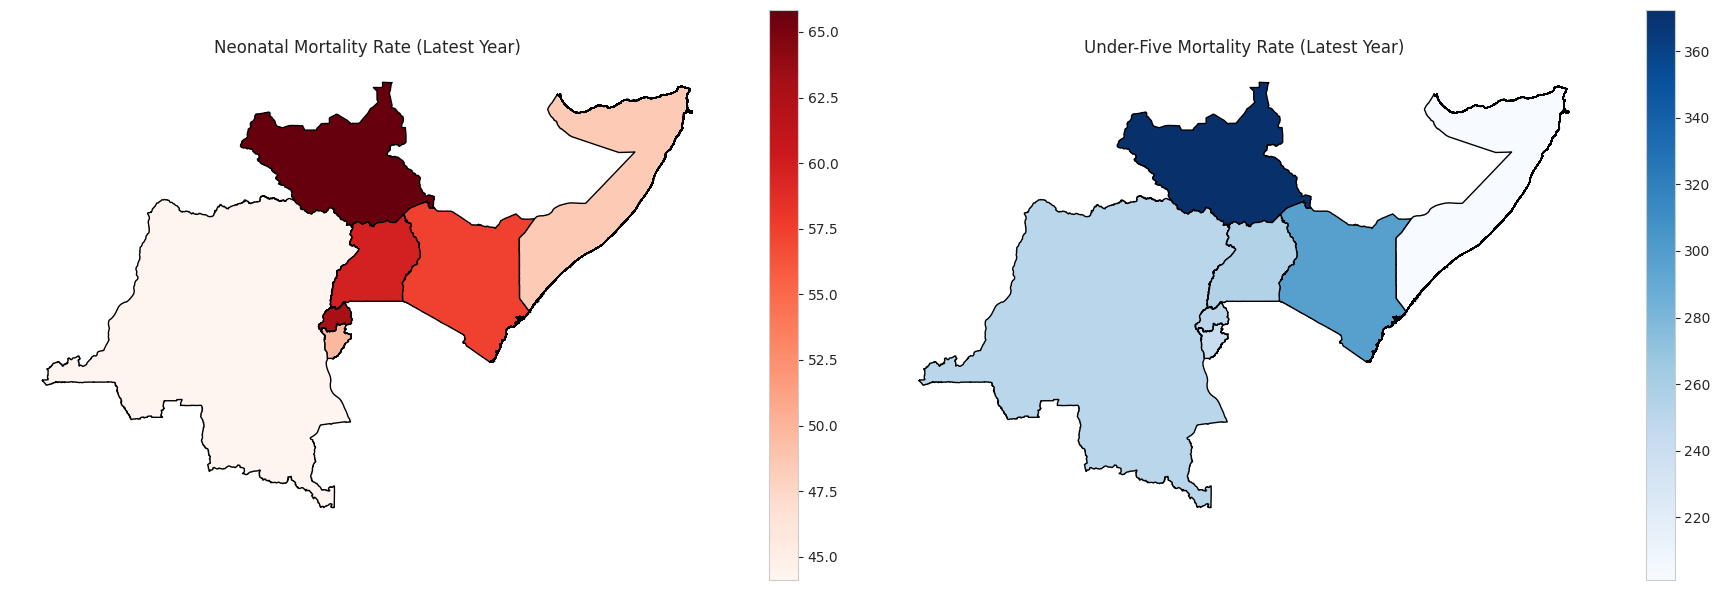

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Merge data with shapefile
eac_shapes_neonatal = eac_shapes.merge(
    latest_neonatal[['ISO3', 'Observation Value']],
    left_on='GID_0',
    right_on='ISO3'
)

# Plot
eac_shapes_neonatal.plot(
    column='Observation Value',
    cmap='Reds',
    legend=True,
    ax=ax[0],
    edgecolor='black'
)
ax[0].set_title('Neonatal Mortality Rate (Latest Year)')
ax[0].axis('off')

# Under-five mortality
eac_shapes_ufm = eac_shapes.merge(
    latest_ufm[['ISO3', 'Observation Value']],
    left_on='GID_0',
    right_on='ISO3'
)

eac_shapes_ufm.plot(
    column='Observation Value',
    cmap='Blues',
    legend=True,
    ax=ax[1],
    edgecolor='black'
)
ax[1].set_title('Under-Five Mortality Rate (Latest Year)')
ax[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Visualization 2: Mortality Trends Over Time
## Neonatal Mortality Trend

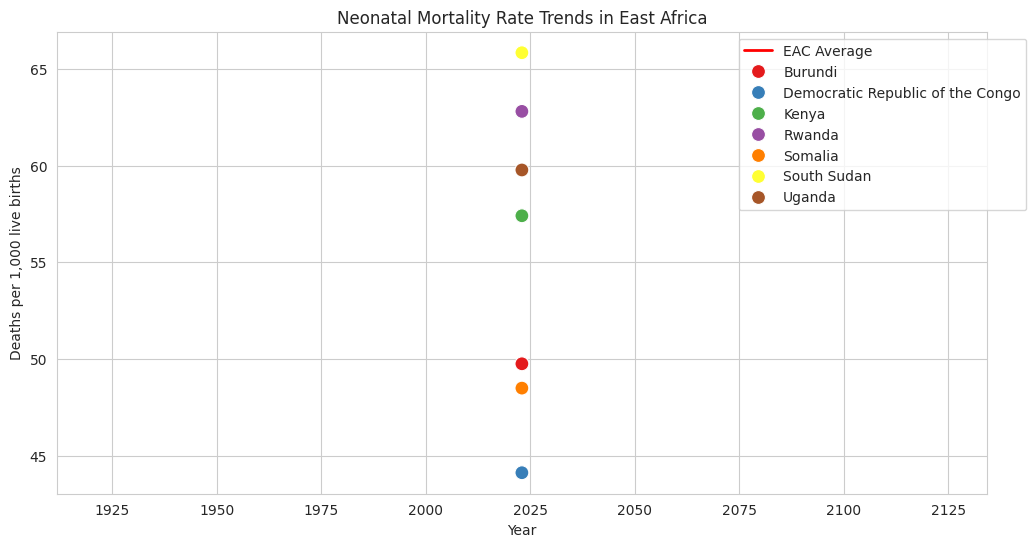

In [49]:
plt.figure(figsize=(12, 6))

# Compute EAC average
neonatal_avg = latest_neonatal.groupby('Year')['Observation Value'].mean().reset_index()

# Plot
sns.lineplot(
    data=neonatal_avg,
    x='Year',
    y='Observation Value',
    color='red',
    label='EAC Average',
    linewidth=2
)

# Add country points
sns.scatterplot(
    data=latest_neonatal,
    x='Year',
    y='Observation Value',
    hue='Geographic area',
    palette='Set1',
    s=100
)

plt.title('Neonatal Mortality Rate Trends in East Africa')
plt.ylabel('Deaths per 1,000 live births')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

### Under-Five Mortality Trend

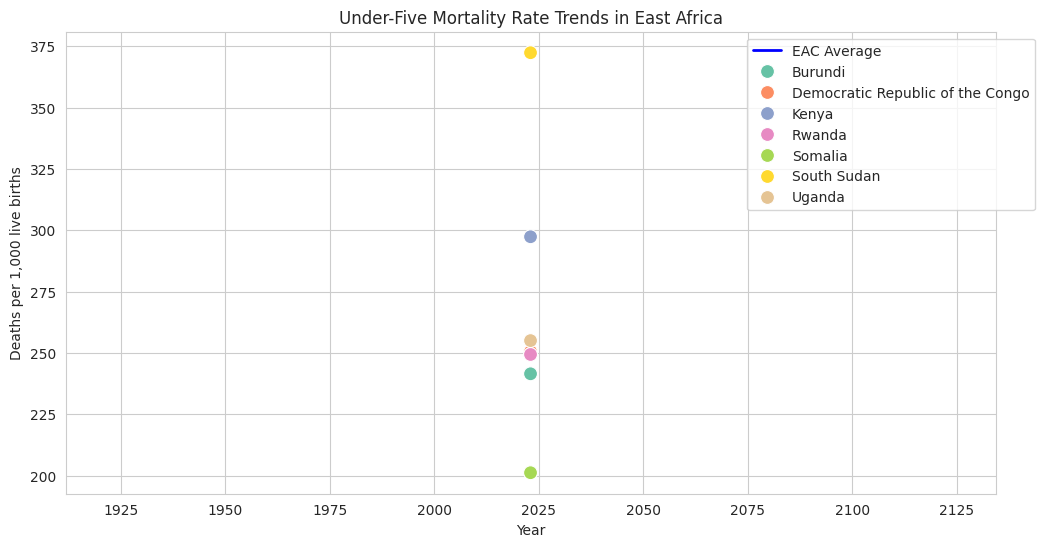

In [50]:
plt.figure(figsize=(12, 6))

ufm_avg = latest_ufm.groupby('Year')['Observation Value'].mean().reset_index()

sns.lineplot(
    data=ufm_avg,
    x='Year',
    y='Observation Value',
    color='blue',
    label='EAC Average',
    linewidth=2
)

sns.scatterplot(
    data=latest_ufm,
    x='Year',
    y='Observation Value',
    hue='Geographic area',
    palette='Set2',
    s=100
)

plt.title('Under-Five Mortality Rate Trends in East Africa')
plt.ylabel('Deaths per 1,000 live births')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

In [51]:
print("Highest Neonatal Mortality:")
print(latest_neonatal.sort_values('Observation Value', ascending=False).head(3)[['Geographic area', 'Observation Value']])

print("\nHighest Under-Five Mortality:")
print(latest_ufm.sort_values('Observation Value', ascending=False).head(3)[['Geographic area', 'Observation Value']])

Highest Neonatal Mortality:
  Geographic area  Observation Value
5     South Sudan          65.834200
3          Rwanda          62.801270
6          Uganda          59.771253

Highest Under-Five Mortality:
  Geographic area  Observation Value
5     South Sudan         372.396894
2           Kenya         297.370080
6          Uganda         255.032040


## Enhanced East Africa Child Mortality Analysis

In [52]:
from scipy import stats
# Check if confidence interval data exists in ds_df
has_ci = all(col in ds_df.columns for col in ['Lower Bound', 'Upper Bound'])

### 1. Enhanced Trend Plots with Confidence Intervals

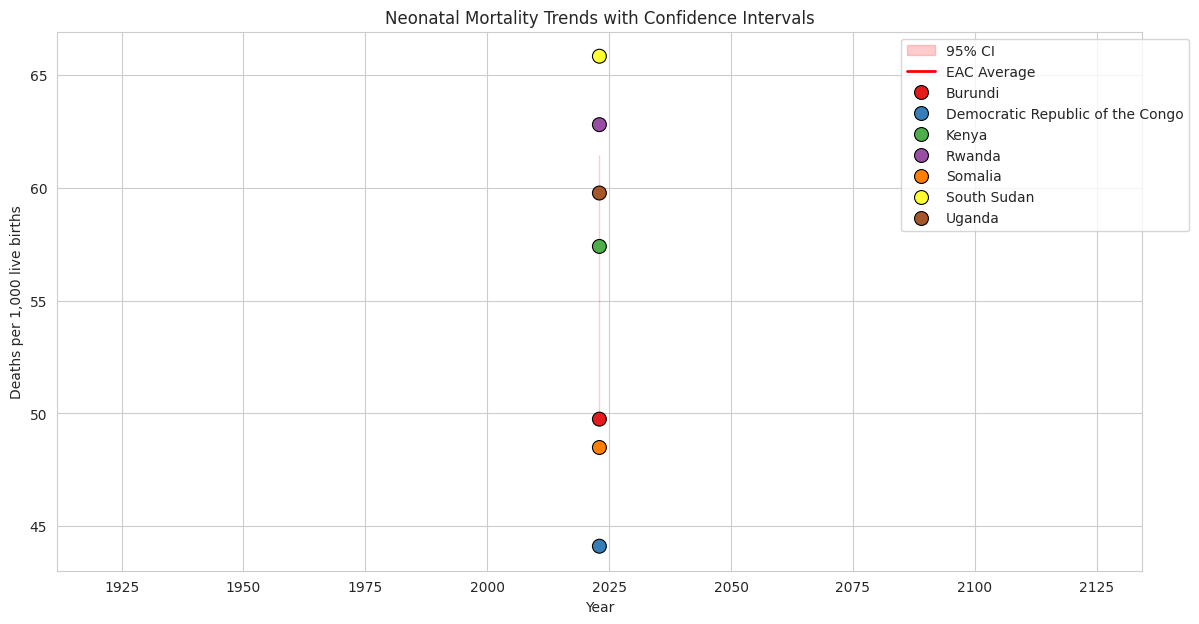

In [53]:
plt.figure(figsize=(14, 7))

# Calculate EAC average with CI
neonatal_avg = latest_neonatal.groupby('Year').agg(
    mean_rate=('Observation Value', 'mean'),
    ci=('Observation Value', lambda x: 1.96*x.std()/np.sqrt(len(x)))
).reset_index()

# Plot average with CI
plt.fill_between(
    neonatal_avg['Year'],
    neonatal_avg['mean_rate'] - neonatal_avg['ci'],
    neonatal_avg['mean_rate'] + neonatal_avg['ci'],
    color='red',
    alpha=0.2,
    label='95% CI'
)
plt.plot(
    neonatal_avg['Year'],
    neonatal_avg['mean_rate'],
    color='red',
    label='EAC Average',
    linewidth=2
)

# Add latest points from latest_neonatal
sns.scatterplot(
    data=latest_neonatal,
    x='Year',
    y='Observation Value',
    hue='Geographic area',
    palette='Set1',
    s=100,
    edgecolor='black'
)

plt.title('Neonatal Mortality Trends with Confidence Intervals')
plt.ylabel('Deaths per 1,000 live births')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

### 2. Annual Reduction Rates (Fixed)

In [54]:
def calculate_arr(df, latest_df):
    results = []
    for country in df['Geographic area'].unique():
        full_series = df[df['Geographic area'] == country].sort_values('Year')
        latest = latest_df[latest_df['Geographic area'] == country].iloc[0]
        
        if len(full_series) > 1:
            start = full_series.iloc[0]
            end = latest  # Using the verified latest point
            years = end['Year'] - start['Year']
            arr = 100 * ((end['Observation Value']/start['Observation Value'])**(1/years) - 1)
            results.append({
                'Country': country,
                'Start Year': start['Year'],
                'End Year': end['Year'],
                'Start Rate': start['Observation Value'],
                'End Rate': end['Observation Value'],
                'ARR (%)': arr,
                'Required ARR for SDG (%)': 100*((25/start['Observation Value'])**(1/(2030-start['Year']))-1)
            })
    return pd.DataFrame(results)

# Using latest data as endpoints
neonatal_arr = calculate_arr(neonatal_clean, latest_neonatal)
ufm_arr = calculate_arr(ufm_clean, latest_ufm)

print("Corrected Annual Reduction Rates:")
display(neonatal_arr.sort_values('ARR (%)'))

Corrected Annual Reduction Rates:


,Country,Start Year,End Year,Start Rate,End Rate,ARR (%),Required ARR for SDG (%)
1,Democratic Republic of the Congo,2007.0,2023.0,45.26000,44.117252,-0.159702,-2.547629
3,Rwanda,1983.0,2023.0,65.23000,62.801270,-0.094816,-2.019841
0,Burundi,1987.0,2023.0,48.74000,49.749877,0.056983,-1.540624
4,Somalia,2006.0,2023.0,46.65000,48.492471,0.228116,-2.565667
6,Uganda,1995.0,2023.0,46.72127,59.771253,0.883614,-1.770773
5,South Sudan,2006.0,2023.0,52.00000,65.834200,1.397294,-3.005444
2,Kenya,1989.0,2023.0,25.37906,57.404098,2.429608,-0.036697


### 3. SDG Target Comparison (Fixed)

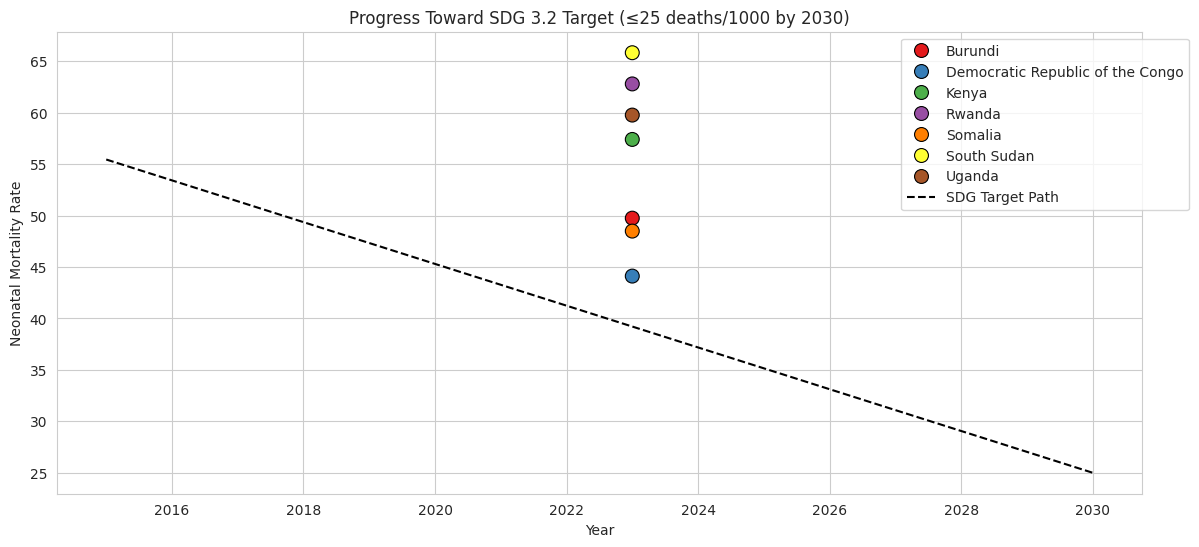

In [55]:
plt.figure(figsize=(14, 6))

# Plot all country trajectories
for country in latest_neonatal['Geographic area'].unique():
    country_data = latest_neonatal[latest_neonatal['Geographic area'] == country].sort_values('Year')
    plt.plot(
        country_data['Year'],
        country_data['Observation Value'],
        color='gray',
        alpha=0.3
    )

# Highlight latest points
sns.scatterplot(
    data=latest_neonatal,
    x='Year',
    y='Observation Value',
    hue='Geographic area',
    palette='Set1',
    s=100,
    edgecolor='black'
)

# Add SDG target trajectory (25 deaths/1000 by 2030)
baseline_year = 2015  # SDG baseline
target_rate = 25
current_avg = latest_neonatal['Observation Value'].mean()
plt.plot(
    [baseline_year, 2030],
    [current_avg, target_rate],
    'k--',
    label='SDG Target Path'
)

plt.title('Progress Toward SDG 3.2 Target (≤25 deaths/1000 by 2030)')
plt.ylabel('Neonatal Mortality Rate')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

### Connected Dashboard

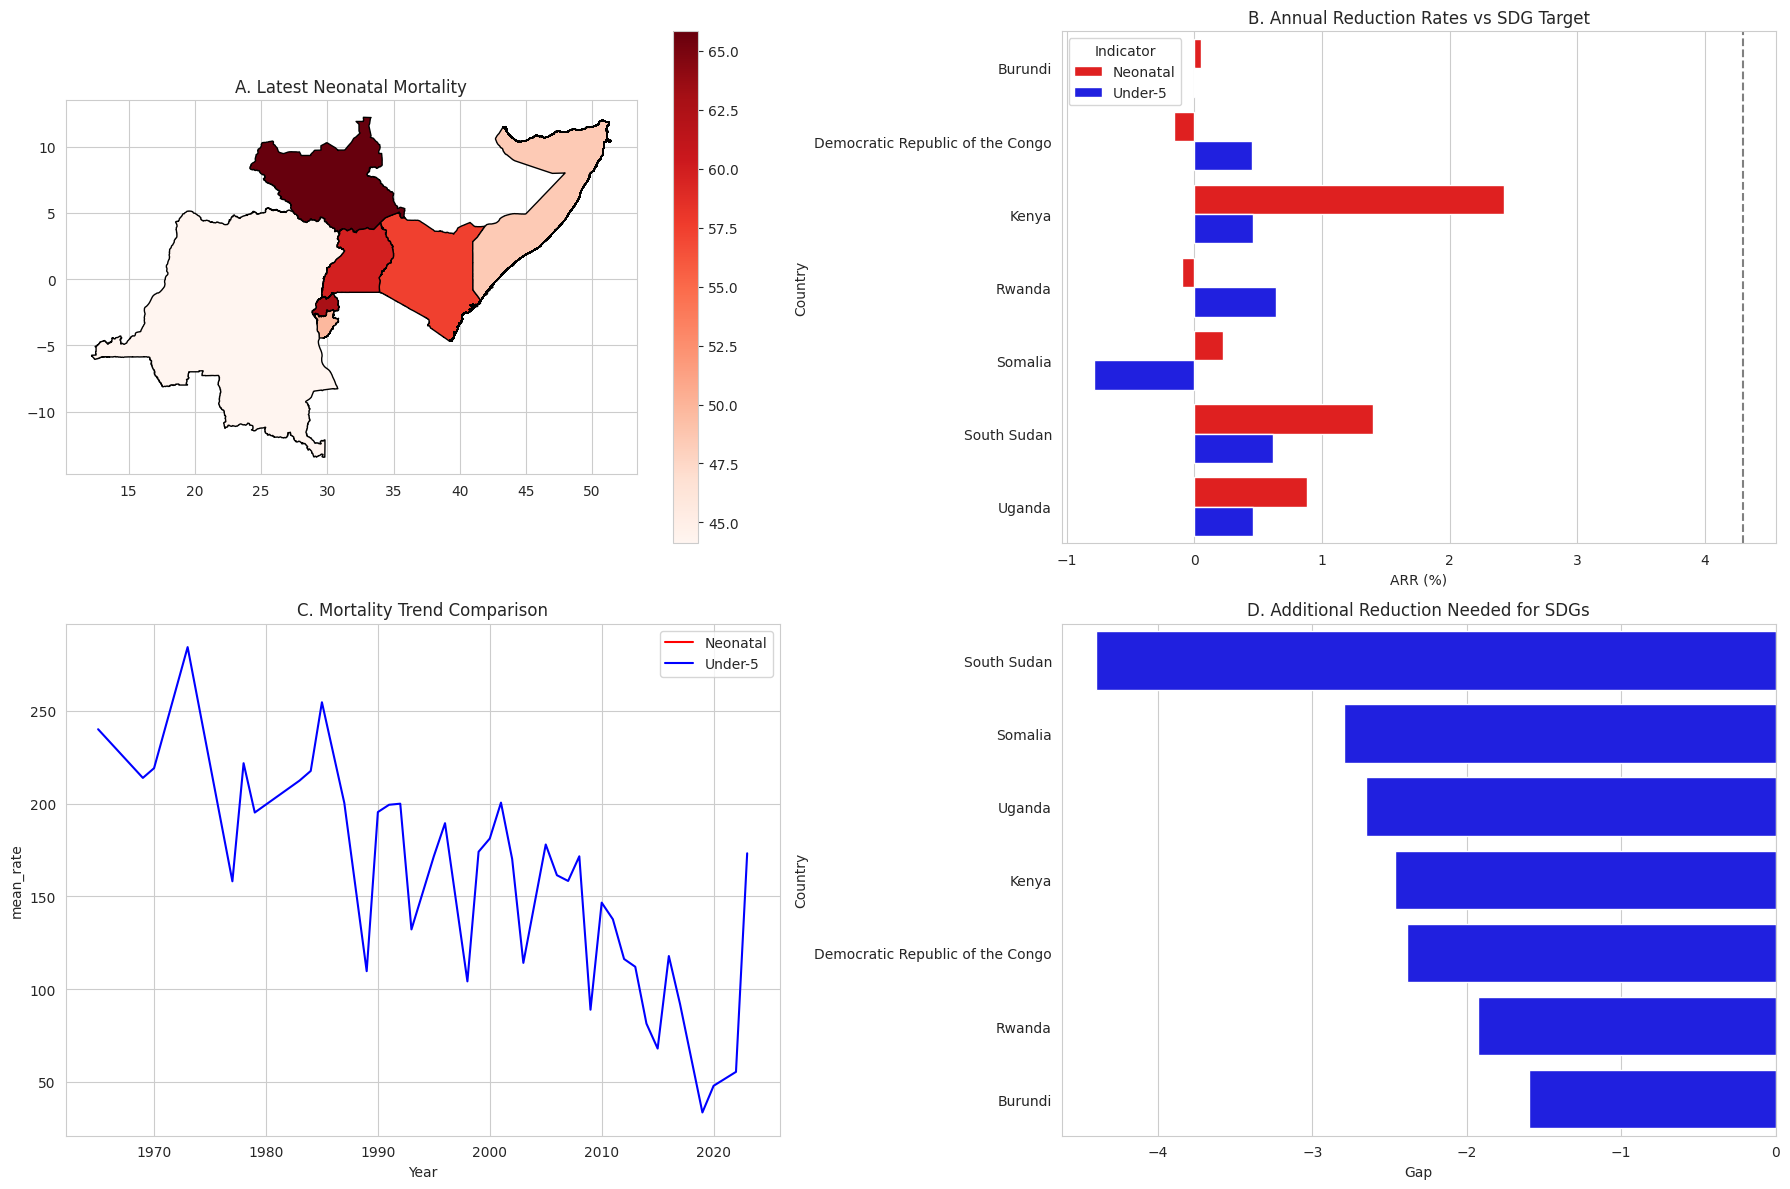

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Panel 1: Neonatal map (using latest_neonatal)
eac_shapes.merge(
    latest_neonatal[['ISO3', 'Observation Value']],
    left_on='GID_0',
    right_on='ISO3'
).plot(
    column='Observation Value',
    cmap='Reds',
    legend=True,
    ax=axes[0,0],
    edgecolor='black'
)
axes[0,0].set_title('A. Latest Neonatal Mortality')

# Panel 2: ARR comparison (using both latest and full series)
arr_comparison = pd.concat([
    neonatal_arr.assign(Indicator='Neonatal'),
    ufm_arr.assign(Indicator='Under-5')
])
sns.barplot(
    data=arr_comparison,
    x='ARR (%)',
    y='Country',
    hue='Indicator',
    ax=axes[0,1],
    palette=['red', 'blue']
)
axes[0,1].axvline(x=4.3, color='gray', linestyle='--')  # Required ARR for SDGs
axes[0,1].set_title('B. Annual Reduction Rates vs SDG Target')

# Panel 3: Trend comparison
sns.lineplot(
    data=neonatal_avg,
    x='Year',
    y='mean_rate',
    color='red',
    label='Neonatal',
    ax=axes[1,0]
)
sns.lineplot(
    data=ufm_clean.groupby('Year')['Observation Value'].mean().reset_index(),
    x='Year',
    y='Observation Value',
    color='blue',
    label='Under-5',
    ax=axes[1,0]
)
axes[1,0].set_title('C. Mortality Trend Comparison')

# Panel 4: SDG gap
gap = neonatal_arr.copy()
gap['Gap'] = gap['Required ARR for SDG (%)'] - gap['ARR (%)']
sns.barplot(
    data=gap.sort_values('Gap'),
    x='Gap',
    y='Country',
    color='blue',
    ax=axes[1,1]
)
axes[1,1].set_title('D. Additional Reduction Needed for SDGs')

plt.tight_layout()
plt.show()

## Findings
###  South Sudan leads in high under-five mortality rate and neonatal mortality rate.
### Rwanda has relatively high neonatal mortality rate than its under-five mortality rate.
### Democratic Republic of Congo shows relatively lower neonatal mortality rate and under-five mortality rate.